In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline



In [16]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

# Feature selection

In [31]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['Class'])
y = df['Class']

feature_names = [feature for feature in df.columns if feature != 'Class']
forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

0.102324707223587

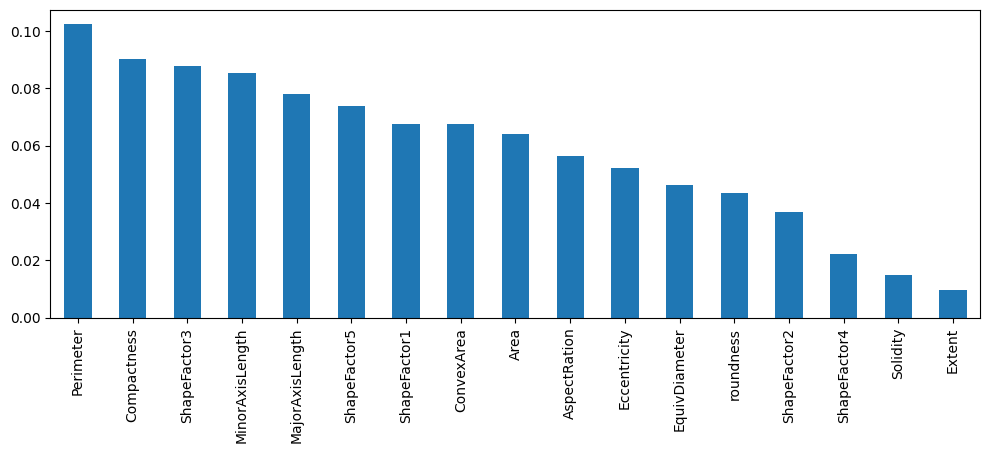

In [83]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12, 4))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
importance_threshold = forest_importances.max()

Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [85]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)
    importances = forest.feature_importances_

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=311)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]

        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    return pd.DataFrame(results)

In [86]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

<Axes: xlabel='num_features'>

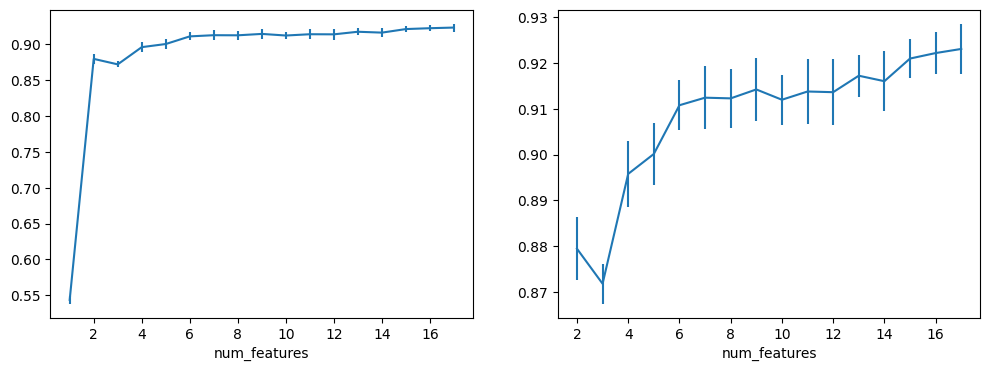

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
results_with_1.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False, ax=axs[0])
results_with_2.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False, ax=axs[1])

In [69]:
results

,num_features,accuracy,std
0,17,0.923216,0.003881
1,16,0.922916,0.004665
2,15,0.922317,0.006160
3,14,0.916618,0.005969
4,13,0.916918,0.006812
5,12,0.913468,0.005995
6,11,0.912868,0.005546
7,10,0.913018,0.005072
8,9,0.912419,0.004803
9,8,0.913618,0.004527


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

def evaluate_feature_importance(X, y, importance_threshold=0.08):
    # Utwórz klasyfikator
    clf = RandomForestClassifier(random_state=42)

    # Dopasuj klasyfikator do danych
    clf.fit(X, y)

    importances = clf.feature_importances_

    # Utwórz DataFrame z ważnościami cech
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # Posortuj cechy według ważności
    feature_importances = feature_importances.sort_values('importance', ascending=True)

    # Usuń wiersze o indeksach od 5 do 11
    feature_importances = feature_importances.drop(feature_importances.index[5:12])

    # Przygotuj listę do przechowywania wyników
    results = []

    # Przytnij cechy jedna po drugiej
    for i in range(len(feature_importances)):
        # Przytnij cechę
        selected_features = feature_importances['feature'].iloc[i:]

        # Przerwij, jeśli ważność ostatniej cechy jest większa niż próg
        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        # Utwórz pipeline
        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        # Oblicz accuracy za pomocą walidacji krzyżowej
        scores = cross_val_score(pipeline, X[selected_features], y, cv=5, scoring='accuracy')

        # Zapisz wynik
        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    # Zwróć wyniki jako DataFrame
    return pd.DataFrame(results)

In [73]:
results2 = evaluate_feature_importance(X, y, 0.08)

In [74]:
results2

,num_features,accuracy,std
0,10,0.925766,0.006113
1,9,0.923967,0.007185
2,8,0.921867,0.004460
3,7,0.915418,0.006051
4,6,0.915418,0.009076
5,5,0.901470,0.008608
